# Deep learning for cell biology 101
This is first part of a tutorial series about deep learning.
Well 90% of this tutorial will be general for everyone that wants to learn about deep learning, the focus will lay on cell biology, and the sometimes uniques problems and solutions needed there.

This first part is about setting up the most simple full flow.
- Loading and preparing data
- Getting a model
- Training a model

To assume the following:
- You have tensorflow (with GPU support) installed. Install via [anaconda](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/) or [pip](https://www.tensorflow.org/install/gpu)
- You have a basic understanding of programming (preferably python)

In [1]:

import os

import cv2
import tensorflow as tf
from tomni import bbox_fitting_center
from random import shuffle
from matplotlib import pyplot as plt

# This is some code for when you only have 1 GPU in your computer.
# If you have multiple or none it will still work fine
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

N_EPOCHES = 20
IMAGE_DIM = 128

C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Loading the data

In this notebook we will be using a maleria dataset: https://lhncbc.nlm.nih.gov/publication/pub9932.
This dataset contains 13779 of images of healthy red blood cells. 
And 13779 of images of maleria infected red blood cells. 

Download and unzip the `cell_images.zip`.

We will do very little clever things in this notebook and try to stay to the basics as much as possible.
This means the results, training speed and prediction speed all can be better.
We will look into better technices later in the series.

We will load all the data directly into our memory from our own hard disk.
This is the easiest way to start but not the most efficient.
In later sessions we will explore better methods.

All images need to have the same size for training.
So we add cropping and/or padding to every image to make them 128x128 without scaling them.
Scaling is something you try to avoid in cell biology because everything will have the same `pixels per mm`.
Applying scaling will break this constant.

In [2]:
# Getting all the paths

data_location_uninfected=r"D:\data\malaria_dataset\Uninfected"
data_location_parasitized=r"D:\data\malaria_dataset\Parasitized"

all_uninfected_paths = [os.path.join(data_location_uninfected, i) for i in os.listdir(data_location_uninfected) if i.endswith(".png")]
all_parasitized_paths = [os.path.join(data_location_parasitized, i) for i in os.listdir(data_location_parasitized) if i.endswith(".png")]

shuffle(all_parasitized_paths)
shuffle(all_uninfected_paths)

In [3]:
def load_and_preprocess(path):
    img = cv2.imread(path)
    img = bbox_fitting_center(img, (IMAGE_DIM, IMAGE_DIM))
    return img

all_uninfected_images = [load_and_preprocess(path) for path in all_uninfected_paths]
all_parasitized_images = [load_and_preprocess(path) for path in all_parasitized_paths]

## Let's have a look at the data we are dealing with

We will vizualize 64 random images and its labels just to see what we are dealing with.
This is done to give an idea of how things look like, and can help us make descision later on.
One of the things that jumps out, is that parasitized blood cells have purple spots and uninfected do not.

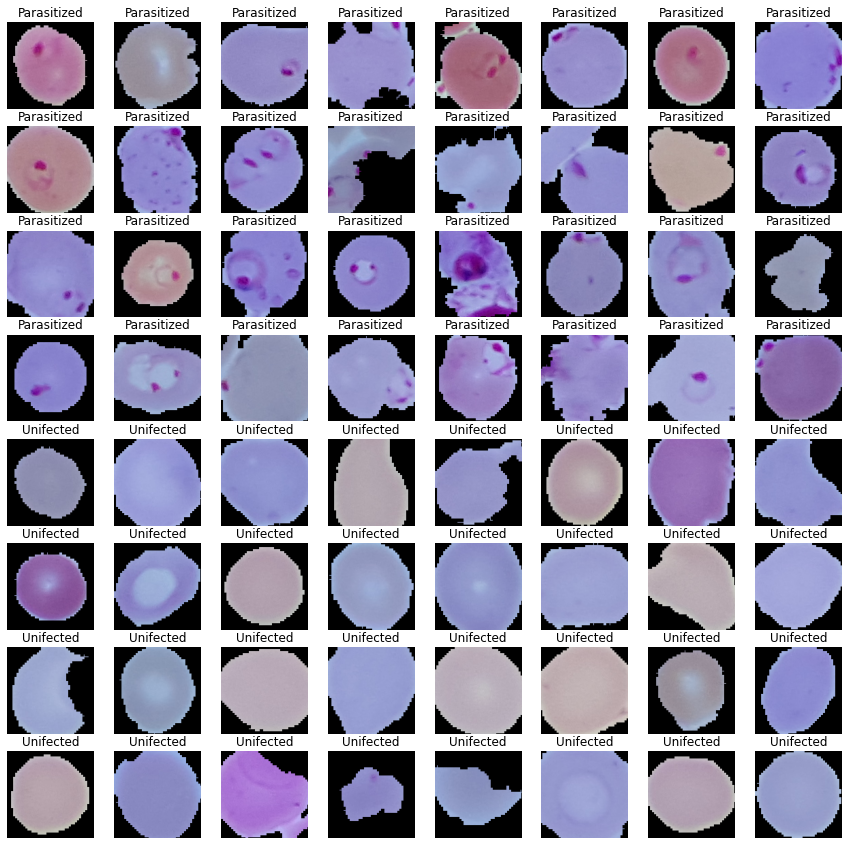

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for i, image in enumerate(all_parasitized_images[:32]):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(image)
  plt.title("Parasitized")
  plt.axis("off")

for i, image in enumerate(all_uninfected_images[:32]):
  ax = plt.subplot(8, 8, i + 33)
  plt.imshow(image)
  plt.title("Uninfected")
  plt.axis("off")

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). 
This is a network is very optimized for speed and accuracy.
B0 means maximum speed, B7 is maximum accuracy.

We can download the model but the model is made the predict a thousand classes.
So we download the model without the top.

The weights is None, meaning we will take random weights for our model (or a fresh model).
For this first tutorial it is good enough but if we add weights that are already trained on something we get [transfer learning](../transfer_learning/02_imagenet_to_malaria_blood_cells.ipynb).
But that is for later.

In [5]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

effienct_net_b0 = EfficientNetB0(include_top=False, weights=None, input_shape=(IMAGE_DIM, IMAGE_DIM, 3))


Lets make a prediction with the model.
If we do so we can see our input image (with the shape `[1, 128, 128, 3]`) it turned into a array of shape `[1, 4, 4, 1280]`.

In here the first dimension is the number of images; 1.

The second and third numbers are the dimensions, 128x128 is the size of the image, 4x4 is the width and height of the output.

The last number is number of features.
Each pixel has 3 values when it gets in (red, green and blue) and 1280 features when it gets out.
What those features are we don't know, the model will determin these when training.

In [6]:
test_image = np.array([all_uninfected_images[0]])

p = effienct_net_b0.predict(test_image)

print(p.shape)

(1, 4, 4, 1280)


We need the change the output size to something that makes sense.
Each picture is either infected or not.
So we can use 1 number to describe them, a 0 if uninfected and a 1 if parasitized.

So the output size should be `[1, 1]`.

To do this we will first add a maxpool2d.
What a maxpool2d is a sliding window maximum filter that also reduces the size of the image.

If we add it with a kernel size of 4x4 our output will be reduced to a `[1, 1, 1, 1280]`.

![max_pool](images/max_pool.png)

In [7]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model

max_pool = MaxPooling2D((4, 4))(effienct_net_b0.output)

input_layer = effienct_net_b0.input
model = Model(input_layer, max_pool)


In [8]:
p = model.predict(test_image)

print(p.shape)

(1, 1, 1, 1280)


Next up we want to reduce the number of features from 1280 to 1.
For this we use another layer, but this time a 2D convolution layer.

Convolution layer are also sliding windows, just like max pool, but they do matrix multiplication instate of maximum filter.
This matrix is called a kernel.
Convolution layers do not reduce the size of the image.

Because our image is already 1x1 we only can fit a kernel of 1x1.

But the kernel has a third dimension, the number of features.
We do not have the give this number Tensorflow we figure it out himself.
It will be 1280 because of the input size of this layer.

We can pick how many of these kernels we want.
Because we want to have an output size of 1 we pick 1.

![Convolution](images/convolution.png)

We also give this layer an activation.
An activation is a function that get applied after this layer.
We use sigmoid.
This is done to make sure all values are inbetween 0 and 1.
If we did not use sigmoid all the values would be inbetween $-\infty$ and $\infty$

In [9]:
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.models import Model

conv2d = Conv2D(1, (1, 1), activation="sigmoid")(max_pool)

model = Model(input_layer, conv2d)

In [10]:
p = model.predict(test_image)

print(p.shape)

(1, 1, 1, 1)


lastly we want get rid of the dimenisions for width and height.
This is what flatten does for us.


In [11]:
flat = Flatten()(conv2d)

model = Model(input_layer, flat)

In [12]:
p = model.predict(test_image)

print(p.shape)

(1, 1)


Great, we have our model.
We can have a look at our full model (efficent net b0 with our own top) by using 
```python 
model.summary()
```

I will skip it because it has a long output without a lot of intresting things (for now).

## Preparing data for training
The data need a little bit of preparation.
- First of all it needs to become 1 list with all data not 2 lists.
- Secondly there needs to be something to predict.

We are training a superviced model, this means we have the input (the image of a bloodcell) and a known label that needs to be predicted (is it parasitized or uninfected).
A model can not predict a class only a number so we replace parasitized with 1 and uninfected with a 0.

This makes sure our expected labels (y) is the same shape as the predictions of the model.

In [13]:
x = all_uninfected_images + all_parasitized_images
y = [0] * len(all_uninfected_images) + [1] * len(all_parasitized_images)

# we make the numpy arrays because tensorflows doesn't like lists
x = np.array(x)
y = np.array(y)

## Loss & optimalization

Now we have our model and data we need 2 more things before we can train our model.

We need a way to determin how well the model does at every given moment.
For this we use the labels and the prediction to calculate 1 number.
The function what does this for us is the loss function.

Secondly we need a way to optimize a model so that every step the loss gets smaller.
This will be our optimizer.

For the loss we will use mean_absolute_error.
This will calculate the average difference between the labels and predictions.

For the optimizer we will use stogastic gradient descent (sgd).
For now it is not very imported to understand them, and there are people who do this way better then I ever can.

Both the optimizer and loss function are standard options in tensorflow.

We will also add a metric for accuracy, just because it is intresting.

In [14]:
model.compile(
    optimizer="sgd", loss="mean_absolute_error", metrics=['accuracy'])

## Training the model

We have our data, we have our model, we have complied our model with a loss function and optimizer.
So now we can start right?

Yes, we, can!

To train the model we use the fit function.
We give it the data.
And the number of times we want to go throught all the data (epochs).

It will output some history we can plot.

*technical part:*

If this goes really slow check if your GPU is used.
If not, try to fix it or be patient.


In [15]:
history = model.fit(
    x, y, epochs=20
)

Epoch 1/20
862/862 [==============================] - 81s 94ms/step - loss: 0.4255 - accuracy: 0.5805
Epoch 2/20
862/862 [==============================] - 81s 94ms/step - loss: 0.3669 - accuracy: 0.6364
Epoch 3/20
862/862 [==============================] - 83s 96ms/step - loss: 0.3444 - accuracy: 0.6578
Epoch 4/20
862/862 [==============================] - 83s 96ms/step - loss: 0.2245 - accuracy: 0.7827
Epoch 5/20
862/862 [==============================] - 83s 96ms/step - loss: 0.1048 - accuracy: 0.9025
Epoch 6/20
862/862 [==============================] - 83s 97ms/step - loss: 0.0823 - accuracy: 0.9218
Epoch 7/20
862/862 [==============================] - 83s 97ms/step - loss: 0.0720 - accuracy: 0.9303
Epoch 8/20
862/862 [==============================] - 84s 97ms/step - loss: 0.0635 - accuracy: 0.9382
Epoch 9/20
862/862 [==============================] - 84s 97ms/step - loss: 0.0613 - accuracy: 0.9407
Epoch 10/20
862/862 [==============================] - 83s 96ms/step - loss: 0.058

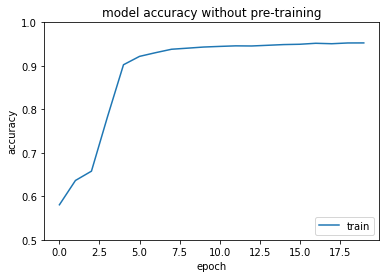

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'test'], loc='lower right')
plt.show()

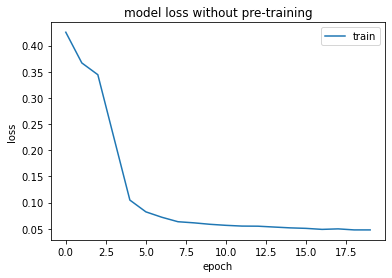

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper right')
plt.show()

Looking at the plots above we can see that the accuracy goes up and the loss goes down.

That is exactly what we want.

Lets now try this model on a few of a pictures.

footnote:

We use now the same pictures for testing and training, this is not a good idea for the same reason you should not give an exam question to a student before the exam.

We will fix that later.

In [18]:
parasitized_predictions = model.predict(np.array(all_parasitized_images[:32]))
uninfected_predictions = model.predict(np.array(all_uninfected_images[:32]))

print("parasitized_predictions",
parasitized_predictions)

print("uninfected_predictions",
uninfected_predictions)

parasitized_predictions [[1.0000000e+00]
 [6.9234374e-10]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999988e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [6.4057433e-11]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]
uninfected_predictions [[3.4475697e-10]
 [6.7759153e-14]
 [1.0546018e-08]
 [5.4016671e-09]
 [9.7797248e-08]
 [3.0599663e-16]
 [1.2375331e-06]
 [6.6759092e-09]
 [8.6219782e-14]
 [9.2348504e-11]
 [2.4197836e-12]
 [1.4591784e-09]
 [3.2983554e-08]
 [6.4797202e-11]
 [3.1415040e-10]
 [3.7868062e-13]
 [3.8210217e-07]
 [2.2651062e-14]
 [2.4846579e-12]
 [2.1744245e-11]
 [3.9392500e-12]
 [5.1299100e-11]
 [2.4593717e-08]
 [4.3969827e-08]


Looking at the results it seems that we have 2 false negatives and that is it.
Not a bad result for our first neural network.

We now have the full flow of training a neural network. Next up we dive deeper into deep learning.

Thank you for you, and tot ziens (Dutch for: see you soon)